In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
# implement data collection procedure on the RTBGym environment

# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [5]:

# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper

# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer



In [6]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

In [7]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [8]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [9]:

trajectory_length_list = [5, 10, 20, 30, 40]
# trajectory_length_list = [5, 10, 20, 30, 40, 80]

# random_state_list = [10, 20, 30]
# random_state_list = [100, 200]
random_state_list = [10, 20, 30, 40, 50, 60, 70]
# random_state_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bias_df_list = []
variance_df_list = []
mse_df_list = []

bias_result_df = DataFrame()
variance_result_df = DataFrame()
mse_result_df = DataFrame()


In [10]:

for trajectory_length in trajectory_length_list:
    # standardized environment for discrete action
    env = gym.make("BasicEnv-continuous-v0", step_per_episode=trajectory_length)
    env_ = OldGymAPIWrapper(env)
    # model
    sac = SAC(
        actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
        critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
        q_func_factory=MeanQFunctionFactory(),
        use_gpu=torch.cuda.is_available(),
        action_scaler=MinMaxActionScaler(
            minimum=env_.action_space.low,   # 0.1
            maximum=env_.action_space.high,  # 10
        ),
    )
    # setup replay buffer
    buffer = ReplayBuffer(
        maxlen=10000,
        env=env_,
    )

    sac.fit_online(
        env_,
        buffer,
        eval_env=env_,
        n_steps=1000,
        n_steps_per_epoch=10,
        update_start_step=10,
        # n_steps=100000,
        # n_steps_per_epoch=1000,
        # update_start_step=1000,
    )
    cql_data = DataFrame()
    sac_data = DataFrame()
    for random_state in random_state_list:
    
        behavior_policy = TruncatedGaussianHead(
            sac, 
            minimum=env.action_space.low,
            maximum=env.action_space.high,
            sigma=np.array([1.0]),
            name="sac_sigma_1.0",
            random_state=random_state,
        )

        # initialize dataset class
        dataset = SyntheticDataset(
            env=env,
            max_episode_steps=env.step_per_episode,
        )

        # collect logged data by a behavior policy
        # skip if there is a preserved logged dataset
        train_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            n_trajectories=1000, 
            obtain_info=False,
            random_state=random_state,
        )
        test_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            n_trajectories=1000, 
            obtain_info=False,
            random_state=random_state + 1,
        )

        # transform offline dataset for d3rlpy
        offlinerl_dataset = MDPDataset(
            observations=train_logged_dataset["state"],
            actions=train_logged_dataset["action"],
            rewards=train_logged_dataset["reward"],
            terminals=train_logged_dataset["done"],
            episode_terminals=train_logged_dataset["done"],
            discrete_action=False,
        )
        train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

        # Use Conservative Q-Learning policy
        cql = CQL(
            actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            q_func_factory=MeanQFunctionFactory(),
            use_gpu=torch.cuda.is_available(),
            action_scaler=MinMaxActionScaler(
                minimum=env_.action_space.low,  # minimum value that policy can take
                maximum=env_.action_space.high,  # maximum value that policy can take
            )
        )

        cql.fit(
            train_episodes,
            eval_episodes=test_episodes,
            n_steps=10000,
            # n_steps=10000,
            scorers={},
        )


        # define evaluation policies (should be deterministic policy)
        cql_ = ContinuousEvalHead(
            base_policy=cql,
            name="cql",
        )
        sac_ = ContinuousEvalHead(
            base_policy=sac, 
            name="sac", 
        )
        evaluation_policies = [cql_, sac_]
        
        # first, prepare OPE inputs
        prep = CreateOPEInput(
            env=env,
            model_args={
                "fqe": {
                    "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
                    "q_func_factory": MeanQFunctionFactory(),
                    "learning_rate": 1e-4,
                    "use_gpu": torch.cuda.is_available(),
                },
            },
            state_scaler=MinMaxScaler(
                minimum=test_logged_dataset["state"].min(axis=0),
                maximum=test_logged_dataset["state"].max(axis=0),
            ),
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            gamma=0.95,
            sigma=0.1,
            device="cuda:0" if torch.cuda.is_available() else "cpu",
        )

        # takes time
        input_dict = prep.obtain_whole_inputs(
            logged_dataset=test_logged_dataset,
            evaluation_policies=evaluation_policies,
            require_value_prediction=True,
            require_weight_prediction=True,
            n_trajectories_on_policy_evaluation=100,
            random_state=random_state,
        )

        ope = OPE(
            logged_dataset=test_logged_dataset,
            ope_estimators=all_estimators,
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            sigma=0.1,
        )

        policy_value_dict = ope.estimate_policy_value(
            input_dict=input_dict,
        )
        
        tmp_cql = DataFrame(policy_value_dict)['cql']
        cql_data = pd.concat([cql_data, tmp_cql], axis=1)
        
        
    # bias = abs(sac_data.mean(axis=1) - sac_data.mean(axis=1)['on_policy'])
    # variance = sac_data.var(axis=1)
    bias = abs(cql_data.mean(axis=1) - cql_data.mean(axis=1)['on_policy'])
    variance = cql_data.var(axis=1)
    mse = bias**2 + variance

    bias_df = DataFrame(DataFrame(bias).stack())\
        .reset_index(1).rename(columns={0: "bias"})
    bias_df["trajectory_length"] = trajectory_length
    bias_df_list.append(bias_df)
    variance_df = DataFrame(DataFrame(variance).stack())\
        .reset_index(1).rename(columns={0: "variance"})
    variance_df["trajectory_length"] = trajectory_length
    variance_df_list.append(variance_df)
    mse_df = DataFrame(DataFrame(mse).stack())\
        .reset_index(1).rename(columns={0: "mse"})
    mse_df["trajectory_length"] = trajectory_length
    mse_df_list.append(mse_df)


    # bias_df[n_trajectories] = bias
    # variance_df[n_trajectories] = variance

# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
mse_result_df = pd.concat(mse_df_list).reset_index(level=0)

2023-04-06 14:20.46 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230406142046
2023-04-06 14:20.46 [debug    ] Fitting action scaler...       action_scler=min_max
2023-04-06 14:20.46 [debug    ] Building model...
2023-04-06 14:20.46 [debug    ] Model has been built.
2023-04-06 14:20.46 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230406142046/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:20.46 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406142046/model_10.pt
2023-04-06 14:20.46 [info     ] SAC_online_20230406142046: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0010728836059570312, 'time_environment_step': 0.00012693405151367187, 'time_step': 0.001239442825317383, 'rollout_return': -0.9498249222030388, 'evaluation': -0.7357852025997986} step=10
2023-04-06 14:20.46 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406142046/model_20.pt
2023-04-06 14:20.46 [info     ] SAC_online_20230406142046: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.0006735086441040039, 'time_environment_step': 7.009506225585938e-05, 'time_step': 0.0007790327072143555, 'rollout_return': 0.7157427419359099, 'evaluation': -0.5037583522245732} step=20
2023-04-06 14:20.46 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406142046/model_30.pt
2023-04-06 14:20.46 [info     ] SAC_online_20230406142046: epoch=3 

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:21.09 [debug    ] RandomIterator is selected.
2023-04-06 14:21.09 [info     ] Directory is created at d3rlpy_logs/CQL_20230406142109
2023-04-06 14:21.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:21.09 [debug    ] Building models...
2023-04-06 14:21.09 [debug    ] Models have been built.
2023-04-06 14:21.09 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406142109/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:25.54 [info     ] CQL_20230406142109: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000879366421699524, 'time_algorithm_update': 0.02680111665725708, 'temp_loss': 3.217786838424206, 'temp': 0.6499058003574609, 'alpha_loss': -30.534355972862244, 'alpha': 1.7954048035025596, 'critic_loss': 31.505280585479735, 'actor_loss': -2.485865074634552, 'time_step': 0.028242667031288148} step=10000
2023-04-06 14:25.54 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406142109/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:25.54 [debug    ] RoundIterator is selected.
2023-04-06 14:25.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230406142554
2023-04-06 14:25.54 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:25.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:25.54 [debug    ] Building models...
2023-04-06 14:25.54 [debug    ] Models have been built.
2023-04-06 14:25.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406142554/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:25.54 [info     ] FQE_20230406142554: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00012121677398681641, 'time_algorithm_update': 0.0017114925384521485, 'loss': 0.1142461483180523, 'time_step': 0.0018902587890625} step=50
2023-04-06 14:25.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406142554/model_50.pt
2023-04-06 14:25.54 [debug    ] RoundIterator is selected.
2023-04-06 14:25.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230406142555
2023-04-06 14:25.55 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:25.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:25.55 [debug    ] Building models...
2023-04-06 14:25.55 [debug    ] Models have been built.
2023-04-06 14:25.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406142555/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_s

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:25.55 [info     ] FQE_20230406142555: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.0001214599609375, 'time_algorithm_update': 0.0019347476959228516, 'loss': 0.10750804930925369, 'time_step': 0.002128887176513672} step=50
2023-04-06 14:25.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406142555/model_50.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/weight_value_learning/minimax_weight_learning_continuous.py:191: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  return self.gamma * (1 - self.gamma) * (base_term @ base_term.T).mean()


[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:27.05 [debug    ] RandomIterator is selected.
2023-04-06 14:27.05 [info     ] Directory is created at d3rlpy_logs/CQL_20230406142705
2023-04-06 14:27.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:27.05 [debug    ] Building models...
2023-04-06 14:27.05 [debug    ] Models have been built.
2023-04-06 14:27.05 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406142705/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:31.47 [info     ] CQL_20230406142705: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008619857311248779, 'time_algorithm_update': 0.02650216805934906, 'temp_loss': 3.2166532760858537, 'temp': 0.6501840037226677, 'alpha_loss': -30.452043620109556, 'alpha': 1.7953278627991676, 'critic_loss': 31.27209370365143, 'actor_loss': -2.351212038064003, 'time_step': 0.027913206481933593} step=10000
2023-04-06 14:31.47 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406142705/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:31.47 [debug    ] RoundIterator is selected.
2023-04-06 14:31.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230406143147
2023-04-06 14:31.47 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:31.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:31.47 [debug    ] Building models...
2023-04-06 14:31.47 [debug    ] Models have been built.
2023-04-06 14:31.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406143147/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:31.47 [info     ] FQE_20230406143147: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00012086868286132812, 'time_algorithm_update': 0.0016260337829589844, 'loss': 0.12276559337973594, 'time_step': 0.0018078231811523438} step=50
2023-04-06 14:31.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406143147/model_50.pt
2023-04-06 14:31.47 [debug    ] RoundIterator is selected.
2023-04-06 14:31.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230406143148
2023-04-06 14:31.48 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:31.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:31.48 [debug    ] Building models...
2023-04-06 14:31.48 [debug    ] Models have been built.
2023-04-06 14:31.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406143148/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:31.48 [info     ] FQE_20230406143148: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00012560367584228517, 'time_algorithm_update': 0.002023587226867676, 'loss': 0.11497975558042527, 'time_step': 0.002217268943786621} step=50
2023-04-06 14:31.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406143148/model_50.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:32.49 [debug    ] RandomIterator is selected.
2023-04-06 14:32.49 [info     ] Directory is created at d3rlpy_logs/CQL_20230406143249
2023-04-06 14:32.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:32.49 [debug    ] Building models...
2023-04-06 14:32.49 [debug    ] Models have been built.
2023-04-06 14:32.49 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406143249/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:37.22 [info     ] CQL_20230406143249: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008291169166564942, 'time_algorithm_update': 0.02565588800907135, 'temp_loss': 3.21186199208498, 'temp': 0.65010163936615, 'alpha_loss': -30.429191414260863, 'alpha': 1.7952547667860985, 'critic_loss': 31.368873721122743, 'actor_loss': -2.4615178711891175, 'time_step': 0.02701475911140442} step=10000
2023-04-06 14:37.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406143249/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:37.22 [debug    ] RoundIterator is selected.
2023-04-06 14:37.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230406143722
2023-04-06 14:37.22 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:37.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:37.22 [debug    ] Building models...
2023-04-06 14:37.22 [debug    ] Models have been built.
2023-04-06 14:37.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406143722/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:37.22 [info     ] FQE_20230406143722: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00012643814086914064, 'time_algorithm_update': 0.0015572738647460938, 'loss': 0.10361990243196488, 'time_step': 0.0017423820495605469} step=50
2023-04-06 14:37.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406143722/model_50.pt
2023-04-06 14:37.22 [debug    ] RoundIterator is selected.
2023-04-06 14:37.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230406143723
2023-04-06 14:37.23 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:37.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:37.23 [debug    ] Building models...
2023-04-06 14:37.23 [debug    ] Models have been built.
2023-04-06 14:37.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406143723/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:37.23 [info     ] FQE_20230406143723: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00011235237121582031, 'time_algorithm_update': 0.0021574735641479493, 'loss': 0.12232306703925133, 'time_step': 0.0023688697814941407} step=50
2023-04-06 14:37.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406143723/model_50.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:38.24 [debug    ] RandomIterator is selected.
2023-04-06 14:38.24 [info     ] Directory is created at d3rlpy_logs/CQL_20230406143824
2023-04-06 14:38.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:38.24 [debug    ] Building models...
2023-04-06 14:38.24 [debug    ] Models have been built.
2023-04-06 14:38.24 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406143824/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:42.52 [info     ] CQL_20230406143824: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008249606370925903, 'time_algorithm_update': 0.025260426044464112, 'temp_loss': 3.2279000393271446, 'temp': 0.6500611425668001, 'alpha_loss': -30.541301986694336, 'alpha': 1.7954795147180558, 'critic_loss': 31.131981859588624, 'actor_loss': -2.20149346126318, 'time_step': 0.026626576566696168} step=10000
2023-04-06 14:42.53 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406143824/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:42.53 [debug    ] RoundIterator is selected.
2023-04-06 14:42.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230406144253
2023-04-06 14:42.53 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:42.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:42.53 [debug    ] Building models...
2023-04-06 14:42.53 [debug    ] Models have been built.
2023-04-06 14:42.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406144253/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:42.53 [info     ] FQE_20230406144253: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00013668060302734374, 'time_algorithm_update': 0.003795480728149414, 'loss': 0.1107507175207138, 'time_step': 0.004073343276977539} step=50
2023-04-06 14:42.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406144253/model_50.pt
2023-04-06 14:42.53 [debug    ] RoundIterator is selected.
2023-04-06 14:42.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230406144254
2023-04-06 14:42.54 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:42.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:42.54 [debug    ] Building models...
2023-04-06 14:42.54 [debug    ] Models have been built.
2023-04-06 14:42.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406144254/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:42.54 [info     ] FQE_20230406144254: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.0001388072967529297, 'time_algorithm_update': 0.0023690938949584963, 'loss': 0.13366591215133666, 'time_step': 0.002613534927368164} step=50
2023-04-06 14:42.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406144254/model_50.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:43.59 [debug    ] RandomIterator is selected.
2023-04-06 14:43.59 [info     ] Directory is created at d3rlpy_logs/CQL_20230406144359
2023-04-06 14:43.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:43.59 [debug    ] Building models...
2023-04-06 14:43.59 [debug    ] Models have been built.
2023-04-06 14:43.59 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406144359/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:48.39 [info     ] CQL_20230406144359: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008583931922912598, 'time_algorithm_update': 0.026358441996574403, 'temp_loss': 3.217079324567318, 'temp': 0.6501363608330488, 'alpha_loss': -30.50623701953888, 'alpha': 1.7953702822327613, 'critic_loss': 31.340714087486266, 'actor_loss': -2.4035871146798136, 'time_step': 0.027772087383270264} step=10000
2023-04-06 14:48.39 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406144359/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:48.39 [debug    ] RoundIterator is selected.
2023-04-06 14:48.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230406144839
2023-04-06 14:48.39 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:48.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:48.39 [debug    ] Building models...
2023-04-06 14:48.39 [debug    ] Models have been built.
2023-04-06 14:48.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406144839/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:48.39 [info     ] FQE_20230406144839: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00017625808715820312, 'time_algorithm_update': 0.0022742605209350587, 'loss': 0.11143815174698829, 'time_step': 0.0025380897521972657} step=50
2023-04-06 14:48.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406144839/model_50.pt
2023-04-06 14:48.39 [debug    ] RoundIterator is selected.
2023-04-06 14:48.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230406144840
2023-04-06 14:48.40 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:48.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:48.40 [debug    ] Building models...
2023-04-06 14:48.40 [debug    ] Models have been built.
2023-04-06 14:48.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406144840/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:48.40 [info     ] FQE_20230406144840: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.0001502704620361328, 'time_algorithm_update': 0.0021567296981811522, 'loss': 0.11869678989052773, 'time_step': 0.0023946428298950197} step=50
2023-04-06 14:48.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406144840/model_50.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:49.46 [debug    ] RandomIterator is selected.
2023-04-06 14:49.46 [info     ] Directory is created at d3rlpy_logs/CQL_20230406144946
2023-04-06 14:49.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:49.46 [debug    ] Building models...
2023-04-06 14:49.46 [debug    ] Models have been built.
2023-04-06 14:49.46 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406144946/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 14:54.22 [info     ] CQL_20230406144946: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008514093160629273, 'time_algorithm_update': 0.025973000168800355, 'temp_loss': 3.2286802178859713, 'temp': 0.6499959541708231, 'alpha_loss': -30.56610055484772, 'alpha': 1.795635796248913, 'critic_loss': 31.29280395965576, 'actor_loss': -2.306225411605835, 'time_step': 0.027380213522911073} step=10000
2023-04-06 14:54.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406144946/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 14:54.23 [debug    ] RoundIterator is selected.
2023-04-06 14:54.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230406145423
2023-04-06 14:54.23 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:54.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:54.23 [debug    ] Building models...
2023-04-06 14:54.23 [debug    ] Models have been built.
2023-04-06 14:54.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406145423/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:54.23 [info     ] FQE_20230406145423: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00018300533294677735, 'time_algorithm_update': 0.0036069393157958985, 'loss': 0.1063662402331829, 'time_step': 0.0038599252700805666} step=50
2023-04-06 14:54.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406145423/model_50.pt
2023-04-06 14:54.23 [debug    ] RoundIterator is selected.
2023-04-06 14:54.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230406145424
2023-04-06 14:54.24 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 14:54.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:54.24 [debug    ] Building models...
2023-04-06 14:54.24 [debug    ] Models have been built.
2023-04-06 14:54.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406145424/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 14:54.24 [info     ] FQE_20230406145424: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00012419700622558593, 'time_algorithm_update': 0.0024262046813964843, 'loss': 0.12297545313835144, 'time_step': 0.002619662284851074} step=50
2023-04-06 14:54.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406145424/model_50.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 14:55.38 [debug    ] RandomIterator is selected.
2023-04-06 14:55.38 [info     ] Directory is created at d3rlpy_logs/CQL_20230406145538
2023-04-06 14:55.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 14:55.38 [debug    ] Building models...
2023-04-06 14:55.38 [debug    ] Models have been built.
2023-04-06 14:55.38 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406145538/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:00.24 [info     ] CQL_20230406145538: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008736164569854737, 'time_algorithm_update': 0.02687458493709564, 'temp_loss': 3.2181088803291322, 'temp': 0.6502361498653889, 'alpha_loss': -30.439552766036986, 'alpha': 1.7950227431297303, 'critic_loss': 31.318572234916687, 'actor_loss': -2.3823490579366684, 'time_step': 0.02831528398990631} step=10000
2023-04-06 15:00.24 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406145538/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:00.24 [debug    ] RoundIterator is selected.
2023-04-06 15:00.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230406150024
2023-04-06 15:00.24 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:00.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:00.24 [debug    ] Building models...
2023-04-06 15:00.24 [debug    ] Models have been built.
2023-04-06 15:00.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406150024/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 15:00.24 [info     ] FQE_20230406150024: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.000148162841796875, 'time_algorithm_update': 0.0030136346817016602, 'loss': 0.11002942696213722, 'time_step': 0.0032766246795654297} step=50
2023-04-06 15:00.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406150024/model_50.pt
2023-04-06 15:00.24 [debug    ] RoundIterator is selected.
2023-04-06 15:00.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230406150025
2023-04-06 15:00.25 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:00.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:00.25 [debug    ] Building models...
2023-04-06 15:00.25 [debug    ] Models have been built.
2023-04-06 15:00.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406150025/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/50 [00:00<?, ?it/s]

2023-04-06 15:00.25 [info     ] FQE_20230406150025: epoch=1 step=50 epoch=1 metrics={'time_sample_batch': 0.00012984752655029297, 'time_algorithm_update': 0.002004694938659668, 'loss': 0.11364572584629058, 'time_step': 0.00221867561340332} step=50
2023-04-06 15:00.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406150025/model_50.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:01.17 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230406150117
2023-04-06 15:01.17 [debug    ] Fitting action scaler...       action_scler=min_max
2023-04-06 15:01.17 [debug    ] Building model...
2023-04-06 15:01.17 [debug    ] Model has been built.
2023-04-06 15:01.17 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230406150117/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:01.17 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406150117/model_10.pt
2023-04-06 15:01.17 [info     ] SAC_online_20230406150117: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0010622739791870117, 'time_environment_step': 8.819103240966796e-05, 'time_step': 0.001178431510925293, 'rollout_return': 0.2485467730411927, 'evaluation': -0.8674985389274712} step=10
2023-04-06 15:01.17 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406150117/model_20.pt
2023-04-06 15:01.17 [info     ] SAC_online_20230406150117: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.0006491422653198242, 'time_environment_step': 9.989738464355469e-05, 'time_step': 0.0007810592651367188, 'rollout_return': 0.9784702076672762, 'evaluation': -0.8299340800332671} step=20
2023-04-06 15:01.17 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406150117/model_30.pt
2023-04-06 15:01.17 [info     ] SAC_online_20230406150117: epoch=3 st

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:01.51 [debug    ] RandomIterator is selected.
2023-04-06 15:01.51 [info     ] Directory is created at d3rlpy_logs/CQL_20230406150151
2023-04-06 15:01.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:01.51 [debug    ] Building models...
2023-04-06 15:01.51 [debug    ] Models have been built.
2023-04-06 15:01.51 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406150151/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:06.30 [info     ] CQL_20230406150151: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008664852619171143, 'time_algorithm_update': 0.026181511282920837, 'temp_loss': 3.22641168102026, 'temp': 0.6501764212578535, 'alpha_loss': -30.710870165252686, 'alpha': 1.7963653560638428, 'critic_loss': 32.14265880622864, 'actor_loss': -3.5243309288978577, 'time_step': 0.027596047472953796} step=10000
2023-04-06 15:06.30 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406150151/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:06.30 [debug    ] RoundIterator is selected.
2023-04-06 15:06.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230406150630
2023-04-06 15:06.30 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:06.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:06.30 [debug    ] Building models...
2023-04-06 15:06.30 [debug    ] Models have been built.
2023-04-06 15:06.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406150630/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:06.30 [info     ] FQE_20230406150630: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00014364957809448242, 'time_algorithm_update': 0.0018231987953186036, 'loss': 0.10723818242549896, 'time_step': 0.00204270601272583} step=100
2023-04-06 15:06.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406150630/model_100.pt
2023-04-06 15:06.30 [debug    ] RoundIterator is selected.
2023-04-06 15:06.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230406150631
2023-04-06 15:06.31 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:06.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:06.31 [debug    ] Building models...
2023-04-06 15:06.31 [debug    ] Models have been built.
2023-04-06 15:06.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406150631/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'ba

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:06.32 [info     ] FQE_20230406150631: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.000152740478515625, 'time_algorithm_update': 0.0029393434524536133, 'loss': 0.10855271384119987, 'time_step': 0.0031906914710998534} step=100
2023-04-06 15:06.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406150631/model_100.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:07.46 [debug    ] RandomIterator is selected.
2023-04-06 15:07.46 [info     ] Directory is created at d3rlpy_logs/CQL_20230406150746
2023-04-06 15:07.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:07.46 [debug    ] Building models...
2023-04-06 15:07.46 [debug    ] Models have been built.
2023-04-06 15:07.46 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406150746/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:12.19 [info     ] CQL_20230406150746: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008527384519577026, 'time_algorithm_update': 0.02572741663455963, 'temp_loss': 3.2232401477575303, 'temp': 0.6500778761088848, 'alpha_loss': -30.683869708633424, 'alpha': 1.7961970849275588, 'critic_loss': 32.20405814170837, 'actor_loss': -3.570961376440525, 'time_step': 0.02713540680408478} step=10000
2023-04-06 15:12.19 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406150746/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:12.19 [debug    ] RoundIterator is selected.
2023-04-06 15:12.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230406151219
2023-04-06 15:12.19 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:12.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:12.19 [debug    ] Building models...
2023-04-06 15:12.19 [debug    ] Models have been built.
2023-04-06 15:12.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406151219/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:12.20 [info     ] FQE_20230406151219: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00014746665954589843, 'time_algorithm_update': 0.002793745994567871, 'loss': 0.11748224645853042, 'time_step': 0.0030196213722229} step=100
2023-04-06 15:12.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406151219/model_100.pt
2023-04-06 15:12.20 [debug    ] RoundIterator is selected.
2023-04-06 15:12.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230406151220
2023-04-06 15:12.20 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:12.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:12.20 [debug    ] Building models...
2023-04-06 15:12.20 [debug    ] Models have been built.
2023-04-06 15:12.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406151220/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:12.20 [info     ] FQE_20230406151220: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00012785673141479492, 'time_algorithm_update': 0.0017299747467041016, 'loss': 0.10145024105906486, 'time_step': 0.0019295001029968261} step=100
2023-04-06 15:12.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406151220/model_100.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:13.39 [debug    ] RandomIterator is selected.
2023-04-06 15:13.39 [info     ] Directory is created at d3rlpy_logs/CQL_20230406151339
2023-04-06 15:13.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:13.39 [debug    ] Building models...
2023-04-06 15:13.39 [debug    ] Models have been built.
2023-04-06 15:13.39 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406151339/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:18.03 [info     ] CQL_20230406151339: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008104361772537232, 'time_algorithm_update': 0.024878958868980408, 'temp_loss': 3.2219454871058466, 'temp': 0.6499385362118483, 'alpha_loss': -30.679171930885314, 'alpha': 1.7962149734258652, 'critic_loss': 32.18876996459961, 'actor_loss': -3.6014766994476317, 'time_step': 0.026220124793052673} step=10000
2023-04-06 15:18.03 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406151339/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:18.03 [debug    ] RoundIterator is selected.
2023-04-06 15:18.03 [info     ] Directory is created at d3rlpy_logs/FQE_20230406151803
2023-04-06 15:18.03 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:18.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:18.03 [debug    ] Building models...
2023-04-06 15:18.03 [debug    ] Models have been built.
2023-04-06 15:18.03 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406151803/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:18.04 [info     ] FQE_20230406151803: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00014075279235839844, 'time_algorithm_update': 0.0024685740470886232, 'loss': 0.10093103140592576, 'time_step': 0.002684824466705322} step=100
2023-04-06 15:18.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406151803/model_100.pt
2023-04-06 15:18.04 [debug    ] RoundIterator is selected.
2023-04-06 15:18.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230406151804
2023-04-06 15:18.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:18.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:18.04 [debug    ] Building models...
2023-04-06 15:18.04 [debug    ] Models have been built.
2023-04-06 15:18.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406151804/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:18.04 [info     ] FQE_20230406151804: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00013337612152099608, 'time_algorithm_update': 0.0016637897491455077, 'loss': 0.11217913828790188, 'time_step': 0.0018691325187683106} step=100
2023-04-06 15:18.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406151804/model_100.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:19.14 [debug    ] RandomIterator is selected.
2023-04-06 15:19.14 [info     ] Directory is created at d3rlpy_logs/CQL_20230406151914
2023-04-06 15:19.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:19.14 [debug    ] Building models...
2023-04-06 15:19.14 [debug    ] Models have been built.
2023-04-06 15:19.14 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406151914/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:23.46 [info     ] CQL_20230406151914: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008096504211425781, 'time_algorithm_update': 0.025597849011421203, 'temp_loss': 3.2246671844244004, 'temp': 0.6501158742427826, 'alpha_loss': -30.70584912376404, 'alpha': 1.7962185856461526, 'critic_loss': 32.11567962760925, 'actor_loss': -3.475837997698784, 'time_step': 0.026927690267562865} step=10000
2023-04-06 15:23.46 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406151914/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:23.46 [debug    ] RoundIterator is selected.
2023-04-06 15:23.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230406152346
2023-04-06 15:23.46 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:23.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:23.46 [debug    ] Building models...
2023-04-06 15:23.46 [debug    ] Models have been built.
2023-04-06 15:23.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406152346/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:23.46 [info     ] FQE_20230406152346: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00010515928268432617, 'time_algorithm_update': 0.0013140630722045898, 'loss': 0.10812039241194725, 'time_step': 0.0014626574516296387} step=100
2023-04-06 15:23.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406152346/model_100.pt
2023-04-06 15:23.46 [debug    ] RoundIterator is selected.
2023-04-06 15:23.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230406152347
2023-04-06 15:23.47 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:23.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:23.47 [debug    ] Building models...
2023-04-06 15:23.47 [debug    ] Models have been built.
2023-04-06 15:23.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406152347/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:23.47 [info     ] FQE_20230406152347: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00013329267501831056, 'time_algorithm_update': 0.0022051072120666503, 'loss': 0.13226333379745484, 'time_step': 0.002416834831237793} step=100
2023-04-06 15:23.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406152347/model_100.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:24.56 [debug    ] RandomIterator is selected.
2023-04-06 15:24.56 [info     ] Directory is created at d3rlpy_logs/CQL_20230406152456
2023-04-06 15:24.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:24.56 [debug    ] Building models...
2023-04-06 15:24.56 [debug    ] Models have been built.
2023-04-06 15:24.56 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406152456/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:29.00 [info     ] CQL_20230406152456: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007613980531692505, 'time_algorithm_update': 0.022962918090820312, 'temp_loss': 3.220628672838211, 'temp': 0.6500796905457974, 'alpha_loss': -30.631720090103148, 'alpha': 1.795958213531971, 'critic_loss': 32.18445464382172, 'actor_loss': -3.6209793511271475, 'time_step': 0.024219934630393982} step=10000
2023-04-06 15:29.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406152456/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:29.00 [debug    ] RoundIterator is selected.
2023-04-06 15:29.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230406152900
2023-04-06 15:29.00 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:29.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:29.00 [debug    ] Building models...
2023-04-06 15:29.00 [debug    ] Models have been built.
2023-04-06 15:29.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406152900/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:29.00 [info     ] FQE_20230406152900: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00011995315551757813, 'time_algorithm_update': 0.0014151954650878907, 'loss': 0.11047855049371719, 'time_step': 0.0015967559814453124} step=100
2023-04-06 15:29.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406152900/model_100.pt
2023-04-06 15:29.00 [debug    ] RoundIterator is selected.
2023-04-06 15:29.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230406152901
2023-04-06 15:29.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:29.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:29.01 [debug    ] Building models...
2023-04-06 15:29.01 [debug    ] Models have been built.
2023-04-06 15:29.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406152901/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:29.01 [info     ] FQE_20230406152901: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00010253667831420898, 'time_algorithm_update': 0.0014803457260131837, 'loss': 0.11404712468385697, 'time_step': 0.0016389989852905274} step=100
2023-04-06 15:29.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406152901/model_100.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:30.09 [debug    ] RandomIterator is selected.
2023-04-06 15:30.09 [info     ] Directory is created at d3rlpy_logs/CQL_20230406153009
2023-04-06 15:30.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:30.09 [debug    ] Building models...
2023-04-06 15:30.09 [debug    ] Models have been built.
2023-04-06 15:30.09 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406153009/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:34.06 [info     ] CQL_20230406153009: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007466749906539917, 'time_algorithm_update': 0.022362761163711546, 'temp_loss': 3.2250725078105926, 'temp': 0.6500409982055426, 'alpha_loss': -30.70332048625946, 'alpha': 1.7964123974680901, 'critic_loss': 32.22715213031769, 'actor_loss': -3.649477154171467, 'time_step': 0.023609779930114747} step=10000
2023-04-06 15:34.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406153009/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:34.07 [debug    ] RoundIterator is selected.
2023-04-06 15:34.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230406153407
2023-04-06 15:34.07 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:34.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:34.07 [debug    ] Building models...
2023-04-06 15:34.07 [debug    ] Models have been built.
2023-04-06 15:34.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406153407/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:34.07 [info     ] FQE_20230406153407: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00015798091888427734, 'time_algorithm_update': 0.0020670080184936523, 'loss': 0.10612352937459946, 'time_step': 0.002309720516204834} step=100
2023-04-06 15:34.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406153407/model_100.pt
2023-04-06 15:34.07 [debug    ] RoundIterator is selected.
2023-04-06 15:34.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230406153408
2023-04-06 15:34.08 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:34.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:34.08 [debug    ] Building models...
2023-04-06 15:34.08 [debug    ] Models have been built.
2023-04-06 15:34.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406153408/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:34.08 [info     ] FQE_20230406153408: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00011789560317993164, 'time_algorithm_update': 0.0017485690116882324, 'loss': 0.120386396124959, 'time_step': 0.0019428586959838866} step=100
2023-04-06 15:34.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406153408/model_100.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:35.16 [debug    ] RandomIterator is selected.
2023-04-06 15:35.16 [info     ] Directory is created at d3rlpy_logs/CQL_20230406153516
2023-04-06 15:35.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:35.16 [debug    ] Building models...
2023-04-06 15:35.16 [debug    ] Models have been built.
2023-04-06 15:35.16 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406153516/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:39.11 [info     ] CQL_20230406153516: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007390790224075317, 'time_algorithm_update': 0.022144820308685302, 'temp_loss': 3.2341559490799905, 'temp': 0.649996427372098, 'alpha_loss': -30.760147888183592, 'alpha': 1.7962937297463417, 'critic_loss': 31.92065832080841, 'actor_loss': -3.282787117600441, 'time_step': 0.023370389676094054} step=10000
2023-04-06 15:39.11 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406153516/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:39.11 [debug    ] RoundIterator is selected.
2023-04-06 15:39.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230406153911
2023-04-06 15:39.11 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:39.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:39.11 [debug    ] Building models...
2023-04-06 15:39.11 [debug    ] Models have been built.
2023-04-06 15:39.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406153911/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:39.12 [info     ] FQE_20230406153911: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00010804176330566407, 'time_algorithm_update': 0.0013616299629211426, 'loss': 0.10447328738868236, 'time_step': 0.0015185070037841797} step=100
2023-04-06 15:39.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406153911/model_100.pt
2023-04-06 15:39.12 [debug    ] RoundIterator is selected.
2023-04-06 15:39.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230406153912
2023-04-06 15:39.12 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:39.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:39.12 [debug    ] Building models...
2023-04-06 15:39.12 [debug    ] Models have been built.
2023-04-06 15:39.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406153912/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:39.12 [info     ] FQE_20230406153912: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.00011729478836059571, 'time_algorithm_update': 0.0013852310180664062, 'loss': 0.10686973072588443, 'time_step': 0.0015552759170532227} step=100
2023-04-06 15:39.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406153912/model_100.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 15:39.59 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230406153959
2023-04-06 15:39.59 [debug    ] Fitting action scaler...       action_scler=min_max
2023-04-06 15:39.59 [debug    ] Building model...
2023-04-06 15:39.59 [debug    ] Model has been built.
2023-04-06 15:39.59 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230406153959/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:39.59 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406153959/model_10.pt
2023-04-06 15:39.59 [info     ] SAC_online_20230406153959: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0007660150527954102, 'time_environment_step': 5.733966827392578e-05, 'time_step': 0.0008402109146118164, 'evaluation': -1.541004103458156} step=10
2023-04-06 15:39.59 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406153959/model_20.pt
2023-04-06 15:39.59 [info     ] SAC_online_20230406153959: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.0004942893981933593, 'time_environment_step': 4.8208236694335935e-05, 'time_step': 0.0005588293075561524, 'evaluation': -0.8892091165233019} step=20
2023-04-06 15:39.59 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406153959/model_30.pt
2023-04-06 15:39.59 [info     ] SAC_online_20230406153959: epoch=3 step=30 epoch=3 metrics={'time_inference': 0.00044181346893310545, 'time_envi

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:40.50 [debug    ] RandomIterator is selected.
2023-04-06 15:40.50 [info     ] Directory is created at d3rlpy_logs/CQL_20230406154050
2023-04-06 15:40.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:40.50 [debug    ] Building models...
2023-04-06 15:40.50 [debug    ] Models have been built.
2023-04-06 15:40.50 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406154050/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:44.48 [info     ] CQL_20230406154050: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007506984710693359, 'time_algorithm_update': 0.022402518010139465, 'temp_loss': 3.2233319854259492, 'temp': 0.6502043020278215, 'alpha_loss': -30.73267761917114, 'alpha': 1.7966214215636254, 'critic_loss': 32.66420909786224, 'actor_loss': -5.073019507348538, 'time_step': 0.023645742988586425} step=10000
2023-04-06 15:44.48 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406154050/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:44.49 [debug    ] RoundIterator is selected.
2023-04-06 15:44.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230406154449
2023-04-06 15:44.49 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:44.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:44.49 [debug    ] Building models...
2023-04-06 15:44.49 [debug    ] Models have been built.
2023-04-06 15:44.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406154449/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 15:44.49 [info     ] FQE_20230406154449: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00012310266494750978, 'time_algorithm_update': 0.0015306317806243897, 'loss': 0.09925340883433818, 'time_step': 0.001719566583633423} step=200
2023-04-06 15:44.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406154449/model_200.pt
2023-04-06 15:44.49 [debug    ] RoundIterator is selected.
2023-04-06 15:44.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230406154450
2023-04-06 15:44.50 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:44.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:44.50 [debug    ] Building models...
2023-04-06 15:44.50 [debug    ] Models have been built.
2023-04-06 15:44.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406154450/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 15:44.50 [info     ] FQE_20230406154450: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.0001074838638305664, 'time_algorithm_update': 0.0013269007205963135, 'loss': 0.10284078560769558, 'time_step': 0.0014837157726287841} step=200
2023-04-06 15:44.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406154450/model_200.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:46.14 [debug    ] RandomIterator is selected.
2023-04-06 15:46.14 [info     ] Directory is created at d3rlpy_logs/CQL_20230406154614
2023-04-06 15:46.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:46.14 [debug    ] Building models...
2023-04-06 15:46.14 [debug    ] Models have been built.
2023-04-06 15:46.14 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406154614/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:50.33 [info     ] CQL_20230406154614: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007962184190750122, 'time_algorithm_update': 0.024311944031715393, 'temp_loss': 3.220927034306526, 'temp': 0.6501135317862033, 'alpha_loss': -30.721089300727844, 'alpha': 1.7964344505667686, 'critic_loss': 32.895610083961486, 'actor_loss': -5.254956253361702, 'time_step': 0.02565294237136841} step=10000
2023-04-06 15:50.33 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406154614/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:50.33 [debug    ] RoundIterator is selected.
2023-04-06 15:50.33 [info     ] Directory is created at d3rlpy_logs/FQE_20230406155033
2023-04-06 15:50.33 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:50.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:50.33 [debug    ] Building models...
2023-04-06 15:50.33 [debug    ] Models have been built.
2023-04-06 15:50.33 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406155033/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 15:50.33 [info     ] FQE_20230406155033: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00012636184692382812, 'time_algorithm_update': 0.0014963936805725097, 'loss': 0.10820255175232887, 'time_step': 0.0016789889335632323} step=200
2023-04-06 15:50.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406155033/model_200.pt
2023-04-06 15:50.33 [debug    ] RoundIterator is selected.
2023-04-06 15:50.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230406155034
2023-04-06 15:50.34 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:50.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:50.34 [debug    ] Building models...
2023-04-06 15:50.34 [debug    ] Models have been built.
2023-04-06 15:50.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406155034/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 15:50.35 [info     ] FQE_20230406155034: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.0001539945602416992, 'time_algorithm_update': 0.0022686648368835448, 'loss': 0.09177094954997302, 'time_step': 0.0025246679782867433} step=200
2023-04-06 15:50.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406155034/model_200.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:52.05 [debug    ] RandomIterator is selected.
2023-04-06 15:52.05 [info     ] Directory is created at d3rlpy_logs/CQL_20230406155205
2023-04-06 15:52.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:52.05 [debug    ] Building models...
2023-04-06 15:52.05 [debug    ] Models have been built.
2023-04-06 15:52.05 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406155205/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 15:56.14 [info     ] CQL_20230406155205: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007877578496932983, 'time_algorithm_update': 0.02344634325504303, 'temp_loss': 3.2204703558683394, 'temp': 0.649957805877924, 'alpha_loss': -30.723556108093263, 'alpha': 1.7965025730609894, 'critic_loss': 32.62019424266815, 'actor_loss': -4.978888891136647, 'time_step': 0.024761342692375184} step=10000
2023-04-06 15:56.14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406155205/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 15:56.14 [debug    ] RoundIterator is selected.
2023-04-06 15:56.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230406155614
2023-04-06 15:56.14 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:56.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:56.14 [debug    ] Building models...
2023-04-06 15:56.14 [debug    ] Models have been built.
2023-04-06 15:56.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406155614/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 15:56.15 [info     ] FQE_20230406155614: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00012566685676574708, 'time_algorithm_update': 0.0014831030368804932, 'loss': 0.0936506500095129, 'time_step': 0.0016740739345550537} step=200
2023-04-06 15:56.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406155614/model_200.pt
2023-04-06 15:56.15 [debug    ] RoundIterator is selected.
2023-04-06 15:56.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230406155615
2023-04-06 15:56.15 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 15:56.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:56.15 [debug    ] Building models...
2023-04-06 15:56.15 [debug    ] Models have been built.
2023-04-06 15:56.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406155615/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 15:56.15 [info     ] FQE_20230406155615: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00015421271324157716, 'time_algorithm_update': 0.001713188886642456, 'loss': 0.10191949881613255, 'time_step': 0.0019434678554534912} step=200
2023-04-06 15:56.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406155615/model_200.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 15:57.45 [debug    ] RandomIterator is selected.
2023-04-06 15:57.45 [info     ] Directory is created at d3rlpy_logs/CQL_20230406155745
2023-04-06 15:57.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 15:57.45 [debug    ] Building models...
2023-04-06 15:57.45 [debug    ] Models have been built.
2023-04-06 15:57.45 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406155745/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:01.57 [info     ] CQL_20230406155745: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007845134735107421, 'time_algorithm_update': 0.02371960949897766, 'temp_loss': 3.223541213643551, 'temp': 0.6501217988848687, 'alpha_loss': -30.721898812675477, 'alpha': 1.796399512255192, 'critic_loss': 32.54655603179932, 'actor_loss': -4.888493093359471, 'time_step': 0.025037137460708618} step=10000
2023-04-06 16:01.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406155745/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:01.57 [debug    ] RoundIterator is selected.
2023-04-06 16:01.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230406160157
2023-04-06 16:01.57 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:01.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:01.57 [debug    ] Building models...
2023-04-06 16:01.57 [debug    ] Models have been built.
2023-04-06 16:01.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406160157/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 16:01.57 [info     ] FQE_20230406160157: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00013792037963867188, 'time_algorithm_update': 0.0018470454216003417, 'loss': 0.09447848543524742, 'time_step': 0.0020566415786743165} step=200
2023-04-06 16:01.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406160157/model_200.pt
2023-04-06 16:01.57 [debug    ] RoundIterator is selected.
2023-04-06 16:01.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230406160158
2023-04-06 16:01.58 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:01.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:01.58 [debug    ] Building models...
2023-04-06 16:01.58 [debug    ] Models have been built.
2023-04-06 16:01.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406160158/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 16:01.59 [info     ] FQE_20230406160158: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00016095399856567384, 'time_algorithm_update': 0.0015491735935211181, 'loss': 0.12249725654721261, 'time_step': 0.0017705154418945312} step=200
2023-04-06 16:01.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406160158/model_200.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:03.34 [debug    ] RandomIterator is selected.
2023-04-06 16:03.34 [info     ] Directory is created at d3rlpy_logs/CQL_20230406160334
2023-04-06 16:03.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:03.34 [debug    ] Building models...
2023-04-06 16:03.34 [debug    ] Models have been built.
2023-04-06 16:03.34 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406160334/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:07.57 [info     ] CQL_20230406160334: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008098579406738281, 'time_algorithm_update': 0.02471181848049164, 'temp_loss': 3.2211637687325476, 'temp': 0.6500600154429674, 'alpha_loss': -30.73811550884247, 'alpha': 1.7964449366807937, 'critic_loss': 32.84059952144623, 'actor_loss': -5.164169466793537, 'time_step': 0.02607291135787964} step=10000
2023-04-06 16:07.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406160334/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:07.57 [debug    ] RoundIterator is selected.
2023-04-06 16:07.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230406160757
2023-04-06 16:07.57 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:07.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:07.57 [debug    ] Building models...
2023-04-06 16:07.57 [debug    ] Models have been built.
2023-04-06 16:07.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406160757/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 16:07.57 [info     ] FQE_20230406160757: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00011996626853942871, 'time_algorithm_update': 0.0016645705699920655, 'loss': 0.10063930686563254, 'time_step': 0.0018622267246246338} step=200
2023-04-06 16:07.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406160757/model_200.pt
2023-04-06 16:07.57 [debug    ] RoundIterator is selected.
2023-04-06 16:07.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230406160758
2023-04-06 16:07.58 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:07.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:07.58 [debug    ] Building models...
2023-04-06 16:07.58 [debug    ] Models have been built.
2023-04-06 16:07.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406160758/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 16:07.59 [info     ] FQE_20230406160758: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00012225866317749023, 'time_algorithm_update': 0.0016726994514465333, 'loss': 0.09980314632877707, 'time_step': 0.0018585419654846191} step=200
2023-04-06 16:07.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406160758/model_200.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:09.31 [debug    ] RandomIterator is selected.
2023-04-06 16:09.31 [info     ] Directory is created at d3rlpy_logs/CQL_20230406160931
2023-04-06 16:09.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:09.31 [debug    ] Building models...
2023-04-06 16:09.31 [debug    ] Models have been built.
2023-04-06 16:09.31 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406160931/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:13.59 [info     ] CQL_20230406160931: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008100605487823486, 'time_algorithm_update': 0.025194991374015808, 'temp_loss': 3.221779688322544, 'temp': 0.650090582677722, 'alpha_loss': -30.742338323020935, 'alpha': 1.7966266366958619, 'critic_loss': 32.76834442825317, 'actor_loss': -5.167919994282722, 'time_step': 0.026554913353919983} step=10000
2023-04-06 16:13.59 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406160931/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:13.59 [debug    ] RoundIterator is selected.
2023-04-06 16:13.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230406161359
2023-04-06 16:13.59 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:13.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:13.59 [debug    ] Building models...
2023-04-06 16:13.59 [debug    ] Models have been built.
2023-04-06 16:13.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406161359/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 16:14.00 [info     ] FQE_20230406161359: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00017752766609191895, 'time_algorithm_update': 0.002071596384048462, 'loss': 0.10022652801126242, 'time_step': 0.0023314809799194337} step=200
2023-04-06 16:14.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406161359/model_200.pt
2023-04-06 16:14.00 [debug    ] RoundIterator is selected.
2023-04-06 16:14.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230406161400
2023-04-06 16:14.00 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:14.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:14.00 [debug    ] Building models...
2023-04-06 16:14.00 [debug    ] Models have been built.
2023-04-06 16:14.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406161400/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 16:14.00 [info     ] FQE_20230406161400: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00013247370719909668, 'time_algorithm_update': 0.001588207483291626, 'loss': 0.11507405128329992, 'time_step': 0.0017779695987701417} step=200
2023-04-06 16:14.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406161400/model_200.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:15.38 [debug    ] RandomIterator is selected.
2023-04-06 16:15.38 [info     ] Directory is created at d3rlpy_logs/CQL_20230406161538
2023-04-06 16:15.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:15.38 [debug    ] Building models...
2023-04-06 16:15.38 [debug    ] Models have been built.
2023-04-06 16:15.38 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406161538/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:20.07 [info     ] CQL_20230406161538: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008160832643508911, 'time_algorithm_update': 0.025369039463996886, 'temp_loss': 3.2237175473332407, 'temp': 0.6501290307968854, 'alpha_loss': -30.72611559238434, 'alpha': 1.79636509745121, 'critic_loss': 32.473858312797546, 'actor_loss': -4.843042137467862, 'time_step': 0.026736428332328796} step=10000
2023-04-06 16:20.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406161538/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:20.07 [debug    ] RoundIterator is selected.
2023-04-06 16:20.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230406162007
2023-04-06 16:20.07 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:20.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:20.07 [debug    ] Building models...
2023-04-06 16:20.07 [debug    ] Models have been built.
2023-04-06 16:20.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406162007/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 16:20.08 [info     ] FQE_20230406162007: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.0001286637783050537, 'time_algorithm_update': 0.0017304182052612304, 'loss': 0.09273927012458444, 'time_step': 0.001926790475845337} step=200
2023-04-06 16:20.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406162007/model_200.pt
2023-04-06 16:20.08 [debug    ] RoundIterator is selected.
2023-04-06 16:20.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230406162008
2023-04-06 16:20.08 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:20.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:20.08 [debug    ] Building models...
2023-04-06 16:20.08 [debug    ] Models have been built.
2023-04-06 16:20.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406162008/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'ba

Epoch 1/1:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 16:20.08 [info     ] FQE_20230406162008: epoch=1 step=200 epoch=1 metrics={'time_sample_batch': 0.00013116836547851562, 'time_algorithm_update': 0.0015018260478973388, 'loss': 0.09900803143158556, 'time_step': 0.001693648099899292} step=200
2023-04-06 16:20.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406162008/model_200.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 16:21.01 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230406162101
2023-04-06 16:21.01 [debug    ] Fitting action scaler...       action_scler=min_max
2023-04-06 16:21.01 [debug    ] Building model...
2023-04-06 16:21.01 [debug    ] Model has been built.
2023-04-06 16:21.01 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230406162101/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:21.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406162101/model_10.pt
2023-04-06 16:21.01 [info     ] SAC_online_20230406162101: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0013393640518188476, 'time_environment_step': 0.00013005733489990234, 'time_step': 0.00150606632232666, 'evaluation': -0.016381631468627412} step=10
2023-04-06 16:21.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406162101/model_20.pt
2023-04-06 16:21.01 [info     ] SAC_online_20230406162101: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.0009691238403320313, 'time_environment_step': 7.56978988647461e-05, 'time_step': 0.0010698556900024414, 'evaluation': -2.724225873387342} step=20
2023-04-06 16:21.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406162101/model_30.pt
2023-04-06 16:21.01 [info     ] SAC_online_20230406162101: epoch=3 step=30 epoch=3 metrics={'time_inference': 0.0006019830703735352, 'time_enviro

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:22.21 [debug    ] RandomIterator is selected.
2023-04-06 16:22.21 [info     ] Directory is created at d3rlpy_logs/CQL_20230406162221
2023-04-06 16:22.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:22.21 [debug    ] Building models...
2023-04-06 16:22.21 [debug    ] Models have been built.
2023-04-06 16:22.21 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406162221/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:26.47 [info     ] CQL_20230406162221: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008248246908187867, 'time_algorithm_update': 0.025018644428253172, 'temp_loss': 3.2263219549655915, 'temp': 0.6501589863330126, 'alpha_loss': -30.7592756483078, 'alpha': 1.7966959488272667, 'critic_loss': 32.53244501247406, 'actor_loss': -5.626090720188618, 'time_step': 0.026397132563591004} step=10000
2023-04-06 16:26.47 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406162221/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:26.47 [debug    ] RoundIterator is selected.
2023-04-06 16:26.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230406162647
2023-04-06 16:26.47 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:26.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:26.47 [debug    ] Building models...
2023-04-06 16:26.47 [debug    ] Models have been built.
2023-04-06 16:26.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406162647/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:26.48 [info     ] FQE_20230406162647: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00013494094212849935, 'time_algorithm_update': 0.0016799036661783854, 'loss': 0.0928429368014137, 'time_step': 0.0019115440050760904} step=300
2023-04-06 16:26.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406162647/model_300.pt
2023-04-06 16:26.48 [debug    ] RoundIterator is selected.
2023-04-06 16:26.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230406162648
2023-04-06 16:26.48 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:26.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:26.48 [debug    ] Building models...
2023-04-06 16:26.48 [debug    ] Models have been built.
2023-04-06 16:26.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406162648/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:26.48 [info     ] FQE_20230406162648: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00014356533686319986, 'time_algorithm_update': 0.0017734615008036295, 'loss': 0.09716029210637013, 'time_step': 0.002001991271972656} step=300
2023-04-06 16:26.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406162648/model_300.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:28.46 [debug    ] RandomIterator is selected.
2023-04-06 16:28.46 [info     ] Directory is created at d3rlpy_logs/CQL_20230406162846
2023-04-06 16:28.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:28.46 [debug    ] Building models...
2023-04-06 16:28.46 [debug    ] Models have been built.
2023-04-06 16:28.46 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406162846/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:33.18 [info     ] CQL_20230406162846: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008430736303329468, 'time_algorithm_update': 0.025543875145912172, 'temp_loss': 3.2233394408941267, 'temp': 0.65006969409585, 'alpha_loss': -30.735944897651674, 'alpha': 1.7965438538074494, 'critic_loss': 32.52046865520477, 'actor_loss': -5.673735844230652, 'time_step': 0.026955050206184387} step=10000
2023-04-06 16:33.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406162846/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:33.18 [debug    ] RoundIterator is selected.
2023-04-06 16:33.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230406163318
2023-04-06 16:33.18 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:33.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:33.18 [debug    ] Building models...
2023-04-06 16:33.18 [debug    ] Models have been built.
2023-04-06 16:33.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406163318/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:33.19 [info     ] FQE_20230406163318: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00015258153279622396, 'time_algorithm_update': 0.001618035634358724, 'loss': 0.10035353084405263, 'time_step': 0.0018390385309855143} step=300
2023-04-06 16:33.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406163318/model_300.pt
2023-04-06 16:33.19 [debug    ] RoundIterator is selected.
2023-04-06 16:33.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230406163319
2023-04-06 16:33.19 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:33.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:33.19 [debug    ] Building models...
2023-04-06 16:33.19 [debug    ] Models have been built.
2023-04-06 16:33.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406163319/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:33.19 [info     ] FQE_20230406163319: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00015193621317545573, 'time_algorithm_update': 0.0020018696784973146, 'loss': 0.08577397079517445, 'time_step': 0.0022712532679239907} step=300
2023-04-06 16:33.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406163319/model_300.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:35.21 [debug    ] RandomIterator is selected.
2023-04-06 16:35.21 [info     ] Directory is created at d3rlpy_logs/CQL_20230406163521
2023-04-06 16:35.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:35.21 [debug    ] Building models...
2023-04-06 16:35.21 [debug    ] Models have been built.
2023-04-06 16:35.21 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406163521/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:39.50 [info     ] CQL_20230406163521: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008302175760269166, 'time_algorithm_update': 0.025339457774162293, 'temp_loss': 3.2223927104830743, 'temp': 0.6499317512452603, 'alpha_loss': -30.747044370269776, 'alpha': 1.7965828617930413, 'critic_loss': 32.38817959365845, 'actor_loss': -5.490476726710797, 'time_step': 0.026741841220855714} step=10000
2023-04-06 16:39.50 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406163521/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:39.50 [debug    ] RoundIterator is selected.
2023-04-06 16:39.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230406163950
2023-04-06 16:39.50 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:39.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:39.50 [debug    ] Building models...
2023-04-06 16:39.50 [debug    ] Models have been built.
2023-04-06 16:39.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406163950/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:39.51 [info     ] FQE_20230406163950: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.0001480539639790853, 'time_algorithm_update': 0.0020510013898213703, 'loss': 0.08393393923838934, 'time_step': 0.002286109924316406} step=300
2023-04-06 16:39.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406163950/model_300.pt
2023-04-06 16:39.51 [debug    ] RoundIterator is selected.
2023-04-06 16:39.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230406163951
2023-04-06 16:39.51 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:39.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:39.51 [debug    ] Building models...
2023-04-06 16:39.51 [debug    ] Models have been built.
2023-04-06 16:39.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406163951/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'ba

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:39.52 [info     ] FQE_20230406163951: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00013461510340372722, 'time_algorithm_update': 0.0015489713350931803, 'loss': 0.09154413702587287, 'time_step': 0.0017507155736287436} step=300
2023-04-06 16:39.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406163951/model_300.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:41.47 [debug    ] RandomIterator is selected.
2023-04-06 16:41.47 [info     ] Directory is created at d3rlpy_logs/CQL_20230406164147
2023-04-06 16:41.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:41.47 [debug    ] Building models...
2023-04-06 16:41.47 [debug    ] Models have been built.
2023-04-06 16:41.47 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406164147/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:46.01 [info     ] CQL_20230406164147: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007898702621459961, 'time_algorithm_update': 0.02393692181110382, 'temp_loss': 3.2250564457893374, 'temp': 0.6501045071512461, 'alpha_loss': -30.777132860183716, 'alpha': 1.7965555356621743, 'critic_loss': 32.5129782836914, 'actor_loss': -5.561406212198734, 'time_step': 0.025259582448005677} step=10000
2023-04-06 16:46.01 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406164147/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:46.01 [debug    ] RoundIterator is selected.
2023-04-06 16:46.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230406164601
2023-04-06 16:46.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:46.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:46.01 [debug    ] Building models...
2023-04-06 16:46.01 [debug    ] Models have been built.
2023-04-06 16:46.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406164601/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:46.02 [info     ] FQE_20230406164601: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00012490510940551757, 'time_algorithm_update': 0.0015477482477823893, 'loss': 0.08178102783858776, 'time_step': 0.001732943058013916} step=300
2023-04-06 16:46.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406164601/model_300.pt
2023-04-06 16:46.02 [debug    ] RoundIterator is selected.
2023-04-06 16:46.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230406164602
2023-04-06 16:46.02 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:46.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:46.02 [debug    ] Building models...
2023-04-06 16:46.02 [debug    ] Models have been built.
2023-04-06 16:46.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406164602/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:46.03 [info     ] FQE_20230406164602: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00013240178426106772, 'time_algorithm_update': 0.0016347392400105794, 'loss': 0.11594024332861105, 'time_step': 0.0018346563975016276} step=300
2023-04-06 16:46.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406164602/model_300.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:47.59 [debug    ] RandomIterator is selected.
2023-04-06 16:47.59 [info     ] Directory is created at d3rlpy_logs/CQL_20230406164759
2023-04-06 16:47.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:47.59 [debug    ] Building models...
2023-04-06 16:47.59 [debug    ] Models have been built.
2023-04-06 16:47.59 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406164759/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:52.06 [info     ] CQL_20230406164759: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007882058143615723, 'time_algorithm_update': 0.023285362482070922, 'temp_loss': 3.2215934210300445, 'temp': 0.6500606435716152, 'alpha_loss': -30.772021802330016, 'alpha': 1.7965930148601532, 'critic_loss': 32.7800686624527, 'actor_loss': -5.901002379357815, 'time_step': 0.024607589483261107} step=10000
2023-04-06 16:52.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406164759/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:52.07 [debug    ] RoundIterator is selected.
2023-04-06 16:52.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230406165207
2023-04-06 16:52.07 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:52.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:52.07 [debug    ] Building models...
2023-04-06 16:52.07 [debug    ] Models have been built.
2023-04-06 16:52.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406165207/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:52.07 [info     ] FQE_20230406165207: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00011579036712646485, 'time_algorithm_update': 0.0012593269348144531, 'loss': 0.09308755035201709, 'time_step': 0.0014242172241210938} step=300
2023-04-06 16:52.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406165207/model_300.pt
2023-04-06 16:52.07 [debug    ] RoundIterator is selected.
2023-04-06 16:52.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230406165208
2023-04-06 16:52.08 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:52.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:52.08 [debug    ] Building models...
2023-04-06 16:52.08 [debug    ] Models have been built.
2023-04-06 16:52.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406165208/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:52.09 [info     ] FQE_20230406165208: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.0001818545659383138, 'time_algorithm_update': 0.0021814727783203126, 'loss': 0.08802360324809949, 'time_step': 0.002529433568318685} step=300
2023-04-06 16:52.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406165208/model_300.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 16:53.55 [debug    ] RandomIterator is selected.
2023-04-06 16:53.55 [info     ] Directory is created at d3rlpy_logs/CQL_20230406165355
2023-04-06 16:53.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:53.55 [debug    ] Building models...
2023-04-06 16:53.55 [debug    ] Models have been built.
2023-04-06 16:53.55 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406165355/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 16:58.06 [info     ] CQL_20230406165355: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008047237634658814, 'time_algorithm_update': 0.023601949739456177, 'temp_loss': 3.2204392483115196, 'temp': 0.6501114819049835, 'alpha_loss': -30.77844360294342, 'alpha': 1.796801052415371, 'critic_loss': 32.88125173187256, 'actor_loss': -6.076586832988262, 'time_step': 0.024939489579200745} step=10000
2023-04-06 16:58.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406165355/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 16:58.06 [debug    ] RoundIterator is selected.
2023-04-06 16:58.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230406165806
2023-04-06 16:58.06 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:58.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:58.06 [debug    ] Building models...
2023-04-06 16:58.06 [debug    ] Models have been built.
2023-04-06 16:58.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406165806/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:58.07 [info     ] FQE_20230406165806: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00012125651041666666, 'time_algorithm_update': 0.0013918526967366537, 'loss': 0.09380297301958004, 'time_step': 0.0015714414914449056} step=300
2023-04-06 16:58.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406165806/model_300.pt
2023-04-06 16:58.07 [debug    ] RoundIterator is selected.
2023-04-06 16:58.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230406165807
2023-04-06 16:58.07 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 16:58.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 16:58.07 [debug    ] Building models...
2023-04-06 16:58.07 [debug    ] Models have been built.
2023-04-06 16:58.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406165807/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 16:58.08 [info     ] FQE_20230406165807: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00011865536371866862, 'time_algorithm_update': 0.001446816921234131, 'loss': 0.10962722716232141, 'time_step': 0.0016150490442911785} step=300
2023-04-06 16:58.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406165807/model_300.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:00.00 [debug    ] RandomIterator is selected.
2023-04-06 17:00.00 [info     ] Directory is created at d3rlpy_logs/CQL_20230406170000
2023-04-06 17:00.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:00.00 [debug    ] Building models...
2023-04-06 17:00.00 [debug    ] Models have been built.
2023-04-06 17:00.00 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406170000/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 17:04.22 [info     ] CQL_20230406170000: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000811379861831665, 'time_algorithm_update': 0.024632837772369385, 'temp_loss': 3.2244071397066114, 'temp': 0.6501198637425899, 'alpha_loss': -30.76211023197174, 'alpha': 1.7964905177474022, 'critic_loss': 32.474942259597775, 'actor_loss': -5.574375519824028, 'time_step': 0.025984597635269165} step=10000
2023-04-06 17:04.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406170000/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 17:04.23 [debug    ] RoundIterator is selected.
2023-04-06 17:04.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230406170423
2023-04-06 17:04.23 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:04.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:04.23 [debug    ] Building models...
2023-04-06 17:04.23 [debug    ] Models have been built.
2023-04-06 17:04.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406170423/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 17:04.23 [info     ] FQE_20230406170423: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.0001583123207092285, 'time_algorithm_update': 0.001883088747660319, 'loss': 0.08307498436421155, 'time_step': 0.0021201427777608234} step=300
2023-04-06 17:04.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406170423/model_300.pt
2023-04-06 17:04.23 [debug    ] RoundIterator is selected.
2023-04-06 17:04.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230406170424
2023-04-06 17:04.24 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:04.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:04.24 [debug    ] Building models...
2023-04-06 17:04.24 [debug    ] Models have been built.
2023-04-06 17:04.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406170424/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'ba

Epoch 1/1:   0%|          | 0/300 [00:00<?, ?it/s]

2023-04-06 17:04.25 [info     ] FQE_20230406170424: epoch=1 step=300 epoch=1 metrics={'time_sample_batch': 0.00015790700912475585, 'time_algorithm_update': 0.00202347199122111, 'loss': 0.09294033233076333, 'time_step': 0.0022661916414896646} step=300
2023-04-06 17:04.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406170424/model_300.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 17:05.36 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230406170536
2023-04-06 17:05.36 [debug    ] Fitting action scaler...       action_scler=min_max
2023-04-06 17:05.36 [debug    ] Building model...
2023-04-06 17:05.36 [debug    ] Model has been built.
2023-04-06 17:05.36 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230406170536/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:05.37 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406170536/model_10.pt
2023-04-06 17:05.37 [info     ] SAC_online_20230406170536: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0010969877243041993, 'time_environment_step': 0.00010886192321777344, 'time_step': 0.0012342214584350586, 'evaluation': -3.4885439023297984} step=10
2023-04-06 17:05.37 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406170536/model_20.pt
2023-04-06 17:05.37 [info     ] SAC_online_20230406170536: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.0007197141647338867, 'time_environment_step': 7.07864761352539e-05, 'time_step': 0.0008143424987792969, 'evaluation': -0.15345786042944595} step=20
2023-04-06 17:05.37 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406170536/model_30.pt
2023-04-06 17:05.37 [info     ] SAC_online_20230406170536: epoch=3 step=30 epoch=3 metrics={'time_inference': 0.0007569789886474609, 'time_envi

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:07.59 [debug    ] RandomIterator is selected.
2023-04-06 17:07.59 [info     ] Directory is created at d3rlpy_logs/CQL_20230406170759
2023-04-06 17:07.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:07.59 [debug    ] Building models...
2023-04-06 17:07.59 [debug    ] Models have been built.
2023-04-06 17:07.59 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406170759/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 17:12.34 [info     ] CQL_20230406170759: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008923719644546509, 'time_algorithm_update': 0.025825600099563598, 'temp_loss': 3.222891392982006, 'temp': 0.6502147537171841, 'alpha_loss': -30.76825384616852, 'alpha': 1.7967524336457252, 'critic_loss': 32.464341826438904, 'actor_loss': -6.202112713754177, 'time_step': 0.027287952089309692} step=10000
2023-04-06 17:12.34 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406170759/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 17:12.34 [debug    ] RoundIterator is selected.
2023-04-06 17:12.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230406171234
2023-04-06 17:12.34 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:12.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:12.34 [debug    ] Building models...
2023-04-06 17:12.34 [debug    ] Models have been built.
2023-04-06 17:12.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406171234/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:12.35 [info     ] FQE_20230406171234: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00015060365200042725, 'time_algorithm_update': 0.0017025160789489746, 'loss': 0.0851086284313351, 'time_step': 0.001919805407524109} step=400
2023-04-06 17:12.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406171234/model_400.pt
2023-04-06 17:12.35 [debug    ] RoundIterator is selected.
2023-04-06 17:12.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230406171235
2023-04-06 17:12.35 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:12.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:12.35 [debug    ] Building models...
2023-04-06 17:12.35 [debug    ] Models have been built.
2023-04-06 17:12.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406171235/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'ba

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:12.36 [info     ] FQE_20230406171235: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00015009522438049315, 'time_algorithm_update': 0.001843782067298889, 'loss': 0.0894575569126755, 'time_step': 0.0020585179328918455} step=400
2023-04-06 17:12.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406171235/model_400.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:15.15 [debug    ] RandomIterator is selected.
2023-04-06 17:15.15 [info     ] Directory is created at d3rlpy_logs/CQL_20230406171515
2023-04-06 17:15.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:15.15 [debug    ] Building models...
2023-04-06 17:15.15 [debug    ] Models have been built.
2023-04-06 17:15.15 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406171515/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 17:19.56 [info     ] CQL_20230406171515: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009047924518585205, 'time_algorithm_update': 0.026446953392028807, 'temp_loss': 3.220643643593788, 'temp': 0.6501155476719142, 'alpha_loss': -30.769901572036744, 'alpha': 1.7966801872134208, 'critic_loss': 32.545141933631896, 'actor_loss': -6.327803129601478, 'time_step': 0.027920216608047485} step=10000
2023-04-06 17:19.56 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406171515/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 17:19.56 [debug    ] RoundIterator is selected.
2023-04-06 17:19.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230406171956
2023-04-06 17:19.56 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:19.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:19.56 [debug    ] Building models...
2023-04-06 17:19.56 [debug    ] Models have been built.
2023-04-06 17:19.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406171956/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:19.57 [info     ] FQE_20230406171956: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00013714253902435302, 'time_algorithm_update': 0.0015594804286956788, 'loss': 0.08903738051652908, 'time_step': 0.0017656886577606201} step=400
2023-04-06 17:19.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406171956/model_400.pt
2023-04-06 17:19.57 [debug    ] RoundIterator is selected.
2023-04-06 17:19.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230406171957
2023-04-06 17:19.57 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:19.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:19.57 [debug    ] Building models...
2023-04-06 17:19.57 [debug    ] Models have been built.
2023-04-06 17:19.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406171957/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:19.58 [info     ] FQE_20230406171957: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00015404999256134034, 'time_algorithm_update': 0.0018623226881027222, 'loss': 0.07824776140041649, 'time_step': 0.002095326781272888} step=400
2023-04-06 17:19.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406171957/model_400.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:22.29 [debug    ] RandomIterator is selected.
2023-04-06 17:22.29 [info     ] Directory is created at d3rlpy_logs/CQL_20230406172229
2023-04-06 17:22.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:22.29 [debug    ] Building models...
2023-04-06 17:22.29 [debug    ] Models have been built.
2023-04-06 17:22.29 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406172229/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 17:26.52 [info     ] CQL_20230406172229: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008572512149810791, 'time_algorithm_update': 0.024751757645606994, 'temp_loss': 3.222483647584915, 'temp': 0.6499363179296255, 'alpha_loss': -30.7757315656662, 'alpha': 1.7966302574396134, 'critic_loss': 32.46465960235596, 'actor_loss': -6.1694558227181435, 'time_step': 0.026155460238456725} step=10000
2023-04-06 17:26.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406172229/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 17:26.53 [debug    ] RoundIterator is selected.
2023-04-06 17:26.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230406172653
2023-04-06 17:26.53 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:26.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:26.53 [debug    ] Building models...
2023-04-06 17:26.53 [debug    ] Models have been built.
2023-04-06 17:26.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406172653/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:26.53 [info     ] FQE_20230406172653: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00012924492359161376, 'time_algorithm_update': 0.0014998626708984375, 'loss': 0.07379763133823872, 'time_step': 0.0016988331079483031} step=400
2023-04-06 17:26.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406172653/model_400.pt
2023-04-06 17:26.53 [debug    ] RoundIterator is selected.
2023-04-06 17:26.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230406172654
2023-04-06 17:26.54 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:26.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:26.54 [debug    ] Building models...
2023-04-06 17:26.54 [debug    ] Models have been built.
2023-04-06 17:26.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406172654/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:26.56 [info     ] FQE_20230406172654: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.0001570594310760498, 'time_algorithm_update': 0.0022887861728668212, 'loss': 0.08062973031774164, 'time_step': 0.002543020248413086} step=400
2023-04-06 17:26.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406172654/model_400.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:29.29 [debug    ] RandomIterator is selected.
2023-04-06 17:29.29 [info     ] Directory is created at d3rlpy_logs/CQL_20230406172929
2023-04-06 17:29.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:29.29 [debug    ] Building models...
2023-04-06 17:29.29 [debug    ] Models have been built.
2023-04-06 17:29.29 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406172929/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 17:33.38 [info     ] CQL_20230406172929: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008054040670394898, 'time_algorithm_update': 0.023376713347434998, 'temp_loss': 3.223681524217129, 'temp': 0.6501255786627531, 'alpha_loss': -30.77977097644806, 'alpha': 1.7965919505119323, 'critic_loss': 32.414893219566345, 'actor_loss': -6.037815349328518, 'time_step': 0.02470098969936371} step=10000
2023-04-06 17:33.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406172929/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 17:33.38 [debug    ] RoundIterator is selected.
2023-04-06 17:33.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230406173338
2023-04-06 17:33.38 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:33.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:33.38 [debug    ] Building models...
2023-04-06 17:33.38 [debug    ] Models have been built.
2023-04-06 17:33.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406173338/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:33.39 [info     ] FQE_20230406173338: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00012431144714355468, 'time_algorithm_update': 0.0014037525653839112, 'loss': 0.07082716759759933, 'time_step': 0.0015852326154708863} step=400
2023-04-06 17:33.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406173338/model_400.pt
2023-04-06 17:33.39 [debug    ] RoundIterator is selected.
2023-04-06 17:33.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230406173339
2023-04-06 17:33.39 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:33.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:33.39 [debug    ] Building models...
2023-04-06 17:33.39 [debug    ] Models have been built.
2023-04-06 17:33.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406173339/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:33.40 [info     ] FQE_20230406173339: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.0001417452096939087, 'time_algorithm_update': 0.0018089717626571654, 'loss': 0.10567806644365191, 'time_step': 0.0020249396562576293} step=400
2023-04-06 17:33.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406173339/model_400.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:35.56 [debug    ] RandomIterator is selected.
2023-04-06 17:35.56 [info     ] Directory is created at d3rlpy_logs/CQL_20230406173556
2023-04-06 17:35.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:35.56 [debug    ] Building models...
2023-04-06 17:35.56 [debug    ] Models have been built.
2023-04-06 17:35.56 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406173556/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 17:39.57 [info     ] CQL_20230406173556: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007980759143829346, 'time_algorithm_update': 0.0226590785741806, 'temp_loss': 3.22147652258873, 'temp': 0.650053442454338, 'alpha_loss': -30.783245691299438, 'alpha': 1.7966587045669555, 'critic_loss': 32.58430827178955, 'actor_loss': -6.308171254646778, 'time_step': 0.023974867510795594} step=10000
2023-04-06 17:39.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406173556/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 17:39.57 [debug    ] RoundIterator is selected.
2023-04-06 17:39.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230406173957
2023-04-06 17:39.57 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:39.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:39.57 [debug    ] Building models...
2023-04-06 17:39.57 [debug    ] Models have been built.
2023-04-06 17:39.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406173957/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:39.58 [info     ] FQE_20230406173957: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00012183845043182372, 'time_algorithm_update': 0.0013193011283874512, 'loss': 0.08466931514441967, 'time_step': 0.0014941543340682983} step=400
2023-04-06 17:39.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406173957/model_400.pt
2023-04-06 17:39.58 [debug    ] RoundIterator is selected.
2023-04-06 17:39.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230406173958
2023-04-06 17:39.58 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:39.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:39.58 [debug    ] Building models...
2023-04-06 17:39.58 [debug    ] Models have been built.
2023-04-06 17:39.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406173958/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:39.58 [info     ] FQE_20230406173958: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00013589680194854735, 'time_algorithm_update': 0.001597062349319458, 'loss': 0.07629358463920653, 'time_step': 0.0018019336462020874} step=400
2023-04-06 17:39.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406173958/model_400.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:42.14 [debug    ] RandomIterator is selected.
2023-04-06 17:42.14 [info     ] Directory is created at d3rlpy_logs/CQL_20230406174214
2023-04-06 17:42.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:42.14 [debug    ] Building models...
2023-04-06 17:42.14 [debug    ] Models have been built.
2023-04-06 17:42.14 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406174214/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 17:48.00 [info     ] CQL_20230406174214: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006928121328353882, 'time_algorithm_update': 0.033279706168174744, 'temp_loss': 3.2244008553385735, 'temp': 0.6500492007702589, 'alpha_loss': -30.79602854347229, 'alpha': 1.796842410862446, 'critic_loss': 32.748784627723694, 'actor_loss': -6.5540206212162975, 'time_step': 0.03442400770187378} step=10000
2023-04-06 17:48.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406174214/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 17:48.00 [debug    ] RoundIterator is selected.
2023-04-06 17:48.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230406174800
2023-04-06 17:48.00 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:48.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:48.00 [debug    ] Building models...
2023-04-06 17:48.00 [debug    ] Models have been built.
2023-04-06 17:48.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406174800/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:48.00 [info     ] FQE_20230406174800: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 9.527146816253663e-05, 'time_algorithm_update': 0.001051098108291626, 'loss': 0.08450392003171146, 'time_step': 0.0011873459815979004} step=400
2023-04-06 17:48.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406174800/model_400.pt
2023-04-06 17:48.00 [debug    ] RoundIterator is selected.
2023-04-06 17:48.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230406174801
2023-04-06 17:48.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:48.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:48.01 [debug    ] Building models...
2023-04-06 17:48.01 [debug    ] Models have been built.
2023-04-06 17:48.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406174801/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'ba

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:48.02 [info     ] FQE_20230406174801: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 9.779095649719239e-05, 'time_algorithm_update': 0.0010595852136611938, 'loss': 0.10196193905547261, 'time_step': 0.0011930793523788452} step=400
2023-04-06 17:48.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406174801/model_400.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 17:50.13 [debug    ] RandomIterator is selected.
2023-04-06 17:50.13 [info     ] Directory is created at d3rlpy_logs/CQL_20230406175013
2023-04-06 17:50.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:50.14 [debug    ] Building models...
2023-04-06 17:50.14 [debug    ] Models have been built.
2023-04-06 17:50.14 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406175013/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 17:54.15 [info     ] CQL_20230406175013: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007815648555755616, 'time_algorithm_update': 0.022727452063560485, 'temp_loss': 3.224870817708969, 'temp': 0.6501029673457146, 'alpha_loss': -30.768438358688353, 'alpha': 1.796549971807003, 'critic_loss': 32.45420770339966, 'actor_loss': -6.167363374435902, 'time_step': 0.024010938835144043} step=10000
2023-04-06 17:54.15 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406175013/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 17:54.15 [debug    ] RoundIterator is selected.
2023-04-06 17:54.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230406175415
2023-04-06 17:54.15 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:54.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:54.15 [debug    ] Building models...
2023-04-06 17:54.15 [debug    ] Models have been built.
2023-04-06 17:54.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406175415/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:54.16 [info     ] FQE_20230406175415: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.00011328339576721191, 'time_algorithm_update': 0.001278008222579956, 'loss': 0.07294193299952895, 'time_step': 0.0014463293552398682} step=400
2023-04-06 17:54.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406175415/model_400.pt
2023-04-06 17:54.16 [debug    ] RoundIterator is selected.
2023-04-06 17:54.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230406175416
2023-04-06 17:54.16 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 17:54.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 17:54.16 [debug    ] Building models...
2023-04-06 17:54.16 [debug    ] Models have been built.
2023-04-06 17:54.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406175416/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 17:54.17 [info     ] FQE_20230406175416: epoch=1 step=400 epoch=1 metrics={'time_sample_batch': 0.0001182568073272705, 'time_algorithm_update': 0.0012974786758422853, 'loss': 0.08559262830764056, 'time_step': 0.001472454071044922} step=400
2023-04-06 17:54.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406175416/model_400.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
variance_result_df.query("(index == 'dm')")

,index,level_1,variance,trajectory_length
1,dm,0,0.010760,5
18,dm,0,0.011525,10
35,dm,0,0.015105,20
52,dm,0,0.016711,30
69,dm,0,0.018110,40


In [12]:
bias_result_df


,index,level_1,bias,trajectory_length
0,on_policy,0,0.000000e+00,5
1,dm,0,9.353350e-01,5
2,tis,0,2.576391e+07,5
3,pdis,0,5.216358e+06,5
4,dr,0,5.223773e+06,5
...,...,...,...,...
80,sam_is,0,5.823192e+00,40
81,sam_dr,0,5.423011e+00,40
82,sam_snis,0,8.595165e+00,40
83,sam_sndr,0,6.620414e+00,40


In [13]:
import pickle

In [14]:
with open("logs/cql_trajectory_length_variance_result_df.pkl", "wb") as f:
    pickle.dump(variance_result_df, f)

with open("logs/cql_trajectory_length_variance_result_df.pkl", "rb") as f:
    variance_result_df = pickle.load(f)

with open("logs/cql_trajectory_length_bias_result_df.pkl", "wb") as f:
    pickle.dump(bias_result_df, f)

with open("logs/cql_trajectory_length_bias_result_df.pkl", "rb") as f:
    bias_result_df = pickle.load(f)

with open("logs/cql_trajectory_length_mse_result_df.pkl", "wb") as f:
    pickle.dump(mse_result_df, f)

with open("logs/cql_trajectory_length_mse_result_df.pkl", "rb") as f:
    mse_result_df = pickle.load(f)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_18404/2516347578.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


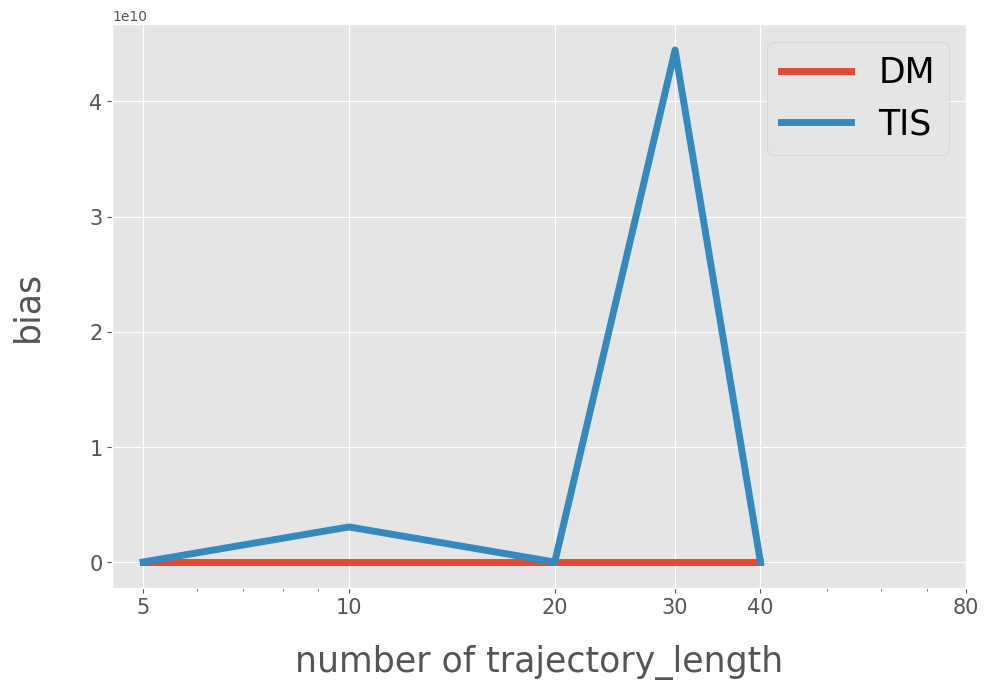

In [15]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5,10,20,30,40,80]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="trajectory_length",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectory_length", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_18404/1921279661.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


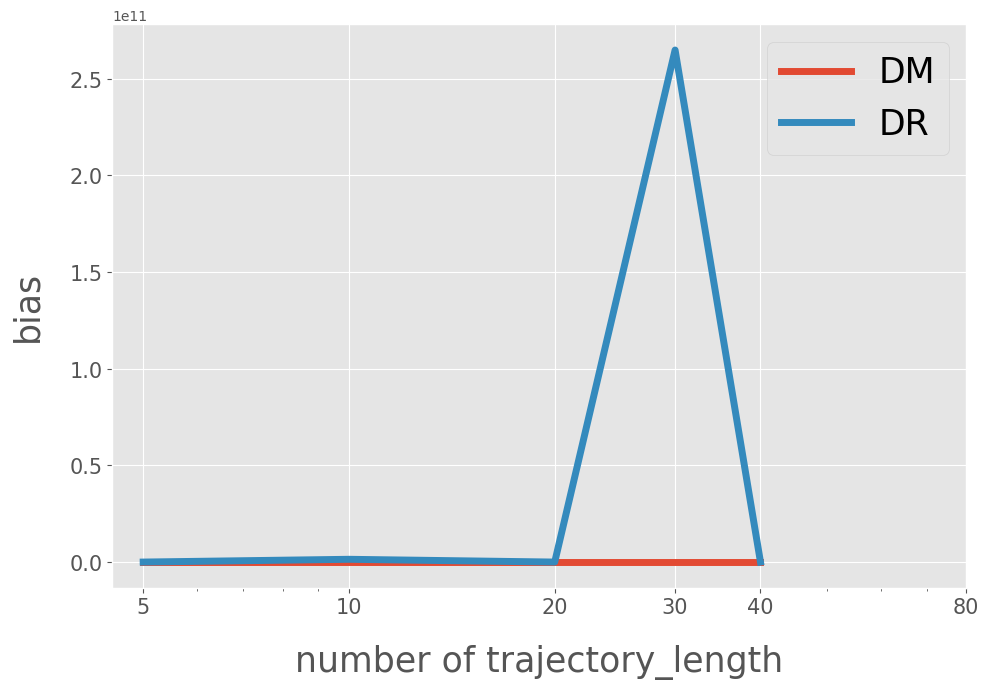

In [16]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5,10,20,30,40,80]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="trajectory_length",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectory_length", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [17]:
variance_result_df

,index,level_1,variance,trajectory_length
0,on_policy,0,1.808649e-02,5
1,dm,0,1.075972e-02,5
2,tis,0,4.539628e+15,5
3,pdis,0,1.849761e+14,5
4,dr,0,1.824907e+14,5
...,...,...,...,...
80,sam_is,0,4.860116e-12,40
81,sam_dr,0,1.811061e-02,40
82,sam_snis,0,4.781886e+01,40
83,sam_sndr,0,1.088907e+01,40


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_18404/3552789092.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


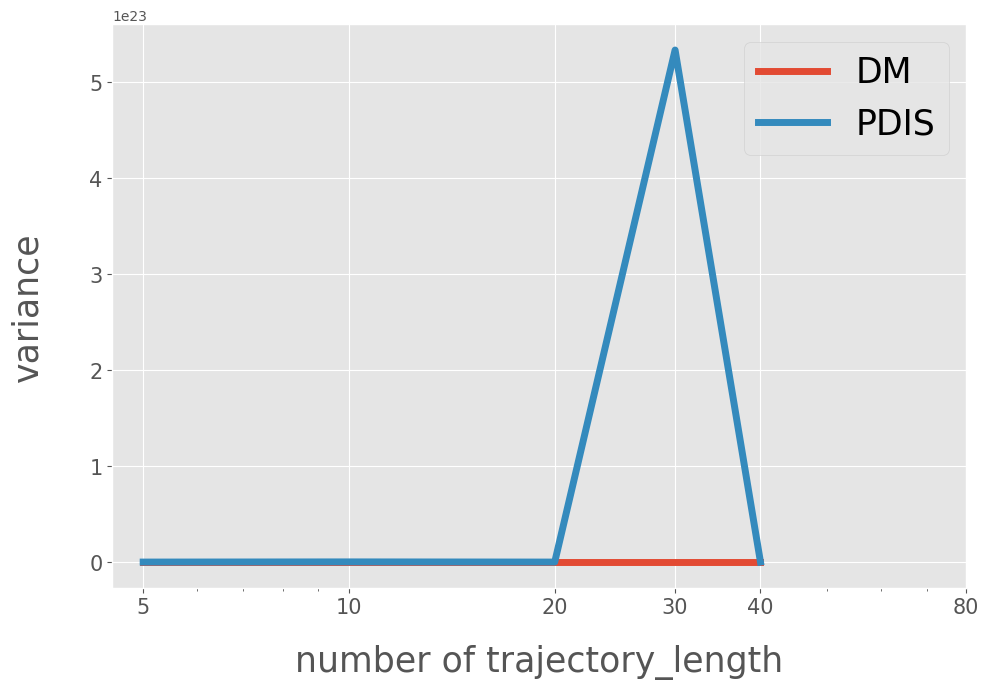

In [18]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5,10,20,30,40,80]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="trajectory_length",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectory_length", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_18404/761401134.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


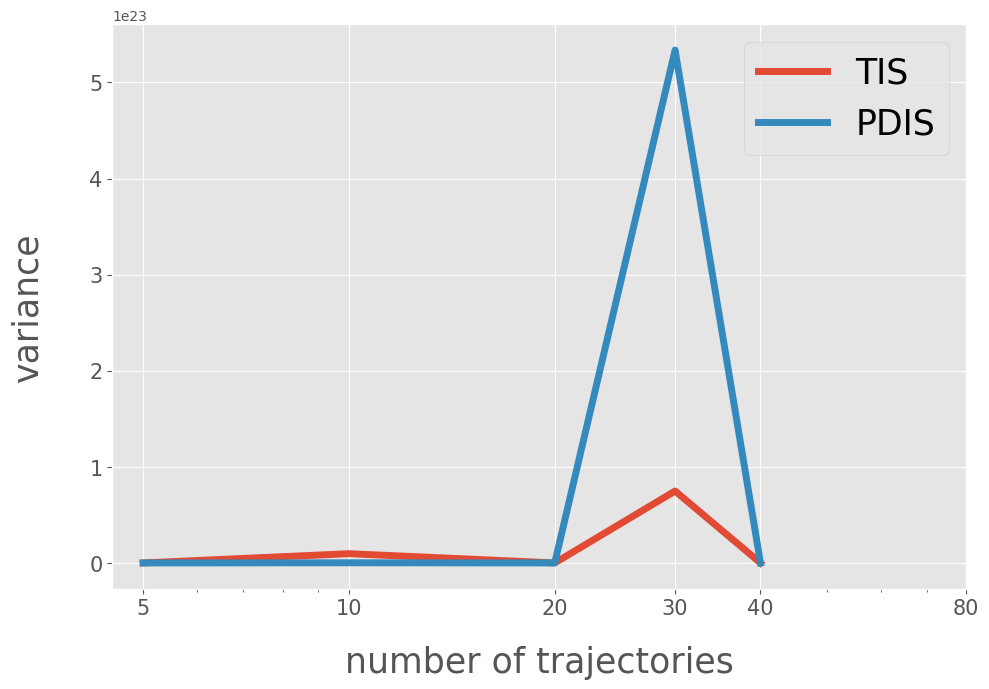

In [19]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [5,10,20,30,40,80]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="trajectory_length",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'tis' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["TIS", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_18404/3430911901.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', True)` for the same effect.

  sns.lineplot(


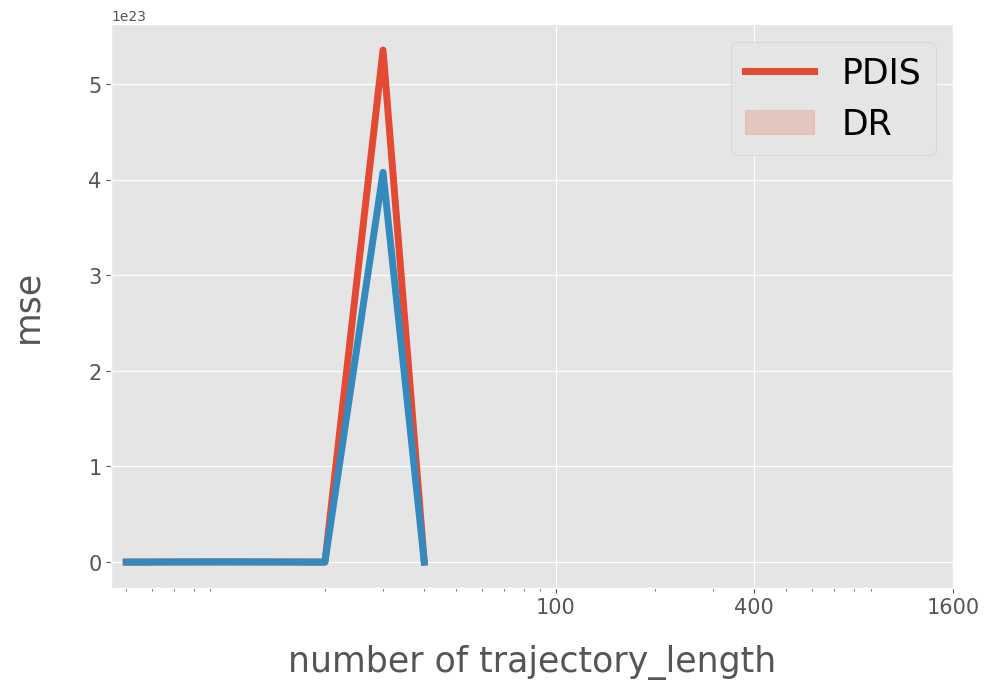

In [20]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="trajectory_length",
    y="mse",
    hue="index",
    ax=ax,
    data=mse_result_df.query("(index == 'pdis' or index == 'dr')"),
    ci=True,
)
# title and legend
ax.legend(["PDIS", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("mse", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectory_length", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)